### References

https://www.tensorflow.org/tutorials/load_data/images

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

https://www.youtube.com/watch?v=yH1cF7GnoIo    

https://www.datacamp.com/community/tutorials/tensorflow-tutorial    



In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np

import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

import re

### Batch size

Batch size is an important parameter when training a network. It can influence speed and generalization, not necessarily in the same direction. There is no golden rule for the batch size but 32 is a commom number to start with.

See: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

Try with different batch sizes.

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 32

### Prepare to load images

In [3]:
data_dir = pathlib.Path('gtsrb/train_images/')
signs = list(data_dir.glob('00001/*'))

classNames = np.array(os.listdir(data_dir))
classNames


array(['00000', '00001', '00002', '00003', '00004', '00005', '00006',
       '00007', '00008', '00009', '00010', '00011', '00012', '00013',
       '00014', '00015', '00016', '00017', '00018', '00019', '00020',
       '00021', '00022', '00023', '00024', '00025', '00026', '00027',
       '00028', '00029', '00030', '00031', '00032', '00033', '00034',
       '00035', '00036', '00037', '00038', '00039', '00040', '00041',
       '00042'], dtype='<U5')

### Auxiliary functions 

In [4]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMAGE_SIZE,IMAGE_SIZE])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def validacao(file_path,valsplit):
    
    parts = tf.strings.split(file_path, os.path.sep)
    seq_num = tf.strings.to_number(tf.strings.split(parts[-1], '_')[0])
    
    #seq_search = re.search("gtsrb/train_images/*/*.png",tf.strings.as_string(file_path))
    
    #if seq_search:
        #seq_number = seq_search(1)
    
    return (int(seq_num)%round(1/valsplit)) == 0

### Loading images takes place in here

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

#listset = tf.data.Dataset.list_files("gtsrb/train_images/*/*.png")
listset = tf.data.Dataset.list_files("gtsrb/train_images/*/*.png")

valsplit = 0.2

valset = listset.filter(lambda f: validacao(f,valsplit))
valset = valset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

trainset = listset.filter(lambda f: not(validacao(f,valsplit)))
trainset = trainset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)


### Information about image shape and size of training set

In [6]:
'''
for image, label in dataset.take(1):
  print("Image shape: ", image.numpy().shape)
  
dataset_length = [i for i,_ in enumerate(dataset)][-1] + 1

print("Total images in dataset: ",dataset_length)
'''
for image, label in valset.take(1):
  print("Image shape: ", image.numpy().shape)
  
valset_length = [i for i,_ in enumerate(valset)][-1] + 1
print("Total images in dataset: ",valset_length)

for image, label in trainset.take(1):
  print("Image shape: ", image.numpy().shape)
  
trainset_length = [i for i,_ in enumerate(trainset)][-1] + 1
print("Total images in dataset: ",trainset_length)


Image shape:  (32, 32, 3)
Total images in dataset:  8340
Image shape:  (32, 32, 3)
Total images in dataset:  30869


### Preparing dataset

In [7]:
'''
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size = dataset_length)
dataset = dataset.batch(batch_size=BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)
dataset = dataset.repeat()
'''
valset = valset.cache()
valset = valset.shuffle(buffer_size = valset_length)
valset = valset.batch(batch_size=BATCH_SIZE)
valset = valset.prefetch(buffer_size=AUTOTUNE)
valset = valset.repeat()

trainset = trainset.cache()
trainset = trainset.shuffle(buffer_size = trainset_length)
trainset = trainset.batch(batch_size=BATCH_SIZE)
trainset = trainset.prefetch(buffer_size=AUTOTUNE)
trainset = trainset.repeat()



### Loading and preparing test dataset

In [8]:
testSplit = 0.8

testset = tf.data.Dataset.list_files("gtsrb/test_images/*/*.png")
print(testset)
testset = testset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
testset = testset.batch(batch_size=BATCH_SIZE)


<ShuffleDataset shapes: (), types: tf.string>


### Show a batch of training images

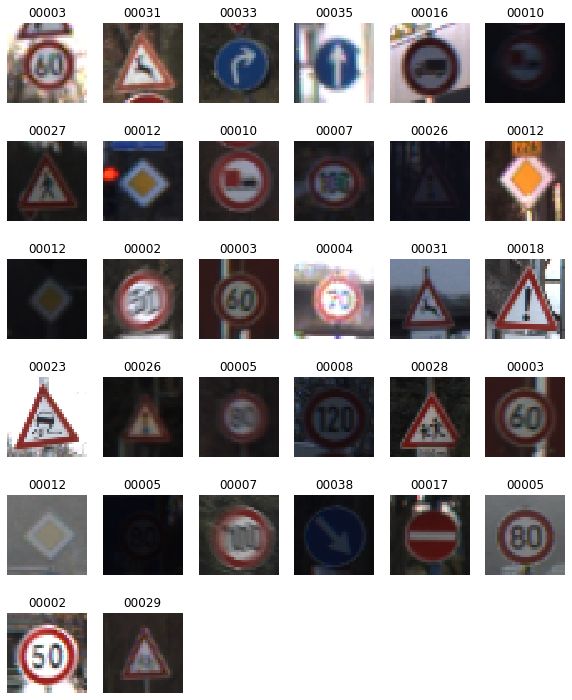

In [9]:
def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(rows, columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')
        
        
image_batch, label_batch = next(iter(valset))        
show_batch(image_batch, label_batch.numpy())

### Build a simple network

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam, Adadelta

def cnn55D3L2FC(classCount, imgSize, channels):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(imgSize, imgSize, channels),
                     activation='relu'))                     
    model.add(Conv2D(32, (3, 3), activation='relu') ) 
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu') )   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu') )   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.5))
 
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    #model.add(GlobalAveragePoolingD())
    
    model.add(Dense(classCount, activation='softmax'))

 
    
    opt = Adam(lr=0.001)
    #opt = Adadelta(lr=1)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ metrics.categorical_accuracy])
    return model

model = cnn55D3L2FC(43, IMAGE_SIZE, 3)


### Draw a diagram of the network

This requires installing some packages, namely graphviz

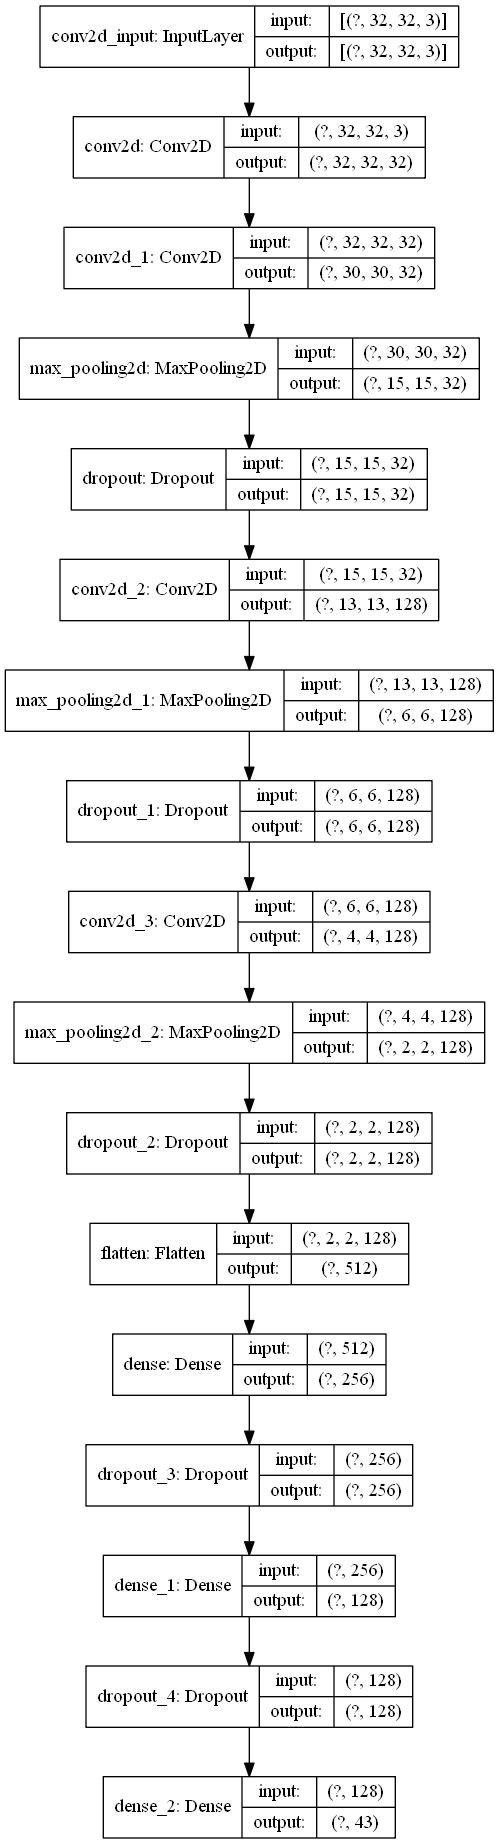

In [11]:
tf.keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

### Display a table with model information

When building a model kee an eye on the number of trainable parameters. Try to keep it below 10 million

In [12]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 128)         0

### Perform a random split to create a validation set

Note that due to the way the GTSRB is build (using video sequences) this is not an ideal approach. Try to partition the set manually, selecting a few sequences for validation purposes. Load the training and validation sets independently.

In [13]:

'''
train_size = int(0.7 * dataset_length)
val_size = int( * dataset_length)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(val_size)
'''

'\ntrain_size = int(0.7 * dataset_length)\nval_size = int( * dataset_length)\ntrain_dataset = dataset.take(train_size)\nval_dataset = dataset.skip(val_size)\n'

### Train the network 

In [14]:
'''
base_model = tf.keras.applications.MobileNetV2(input_shape = (IMAGE_SIZE,IMAGE_SIZE,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(43)

model = tf.keras.Sequential([base_model,global_average_layer,prediction_layer])

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
'''
history = model.fit(trainset, steps_per_epoch = trainset_length/BATCH_SIZE,
          epochs=20, validation_data = valset, validation_steps= valset_length/BATCH_SIZE)


Train for 964.65625 steps, validate for 260.625 steps
Epoch 1/20
965/964 [==============================] - 19s 20ms/step - loss: 2.3982 - categorical_accuracy: 0.3084 - val_loss: 1.0562 - val_categorical_accuracy: 0.6778
Epoch 2/20
965/964 [==============================] - 8s 8ms/step - loss: 0.9064 - categorical_accuracy: 0.7054 - val_loss: 0.4117 - val_categorical_accuracy: 0.8516
Epoch 3/20
965/964 [==============================] - 9s 9ms/step - loss: 0.5023 - categorical_accuracy: 0.8297 - val_loss: 0.2723 - val_categorical_accuracy: 0.9118
Epoch 4/20
965/964 [==============================] - 8s 8ms/step - loss: 0.3604 - categorical_accuracy: 0.8860 - val_loss: 0.1766 - val_categorical_accuracy: 0.9520
Epoch 5/20
965/964 [==============================] - 8s 8ms/step - loss: 0.2761 - categorical_accuracy: 0.9188 - val_loss: 0.1517 - val_categorical_accuracy: 0.9594
Epoch 6/20
965/964 [==============================] - 9s 9ms/step - loss: 0.2192 - categorical_accuracy: 0.9345 - 

### Plot the training history

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


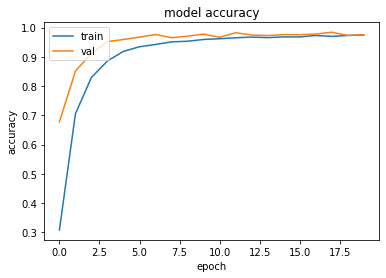

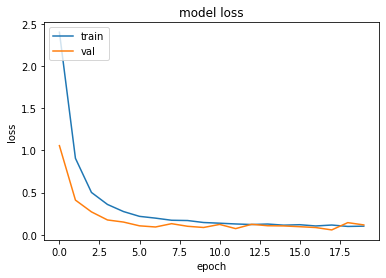

In [15]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluate the model on the test set

This is the accuracy number that really matters

In [16]:
model.evaluate(testset)

395/395 [==============================] - 6s 15ms/step - loss: 0.1014 - categorical_accuracy: 0.9772


[0.10138778091070118, 0.9771972]

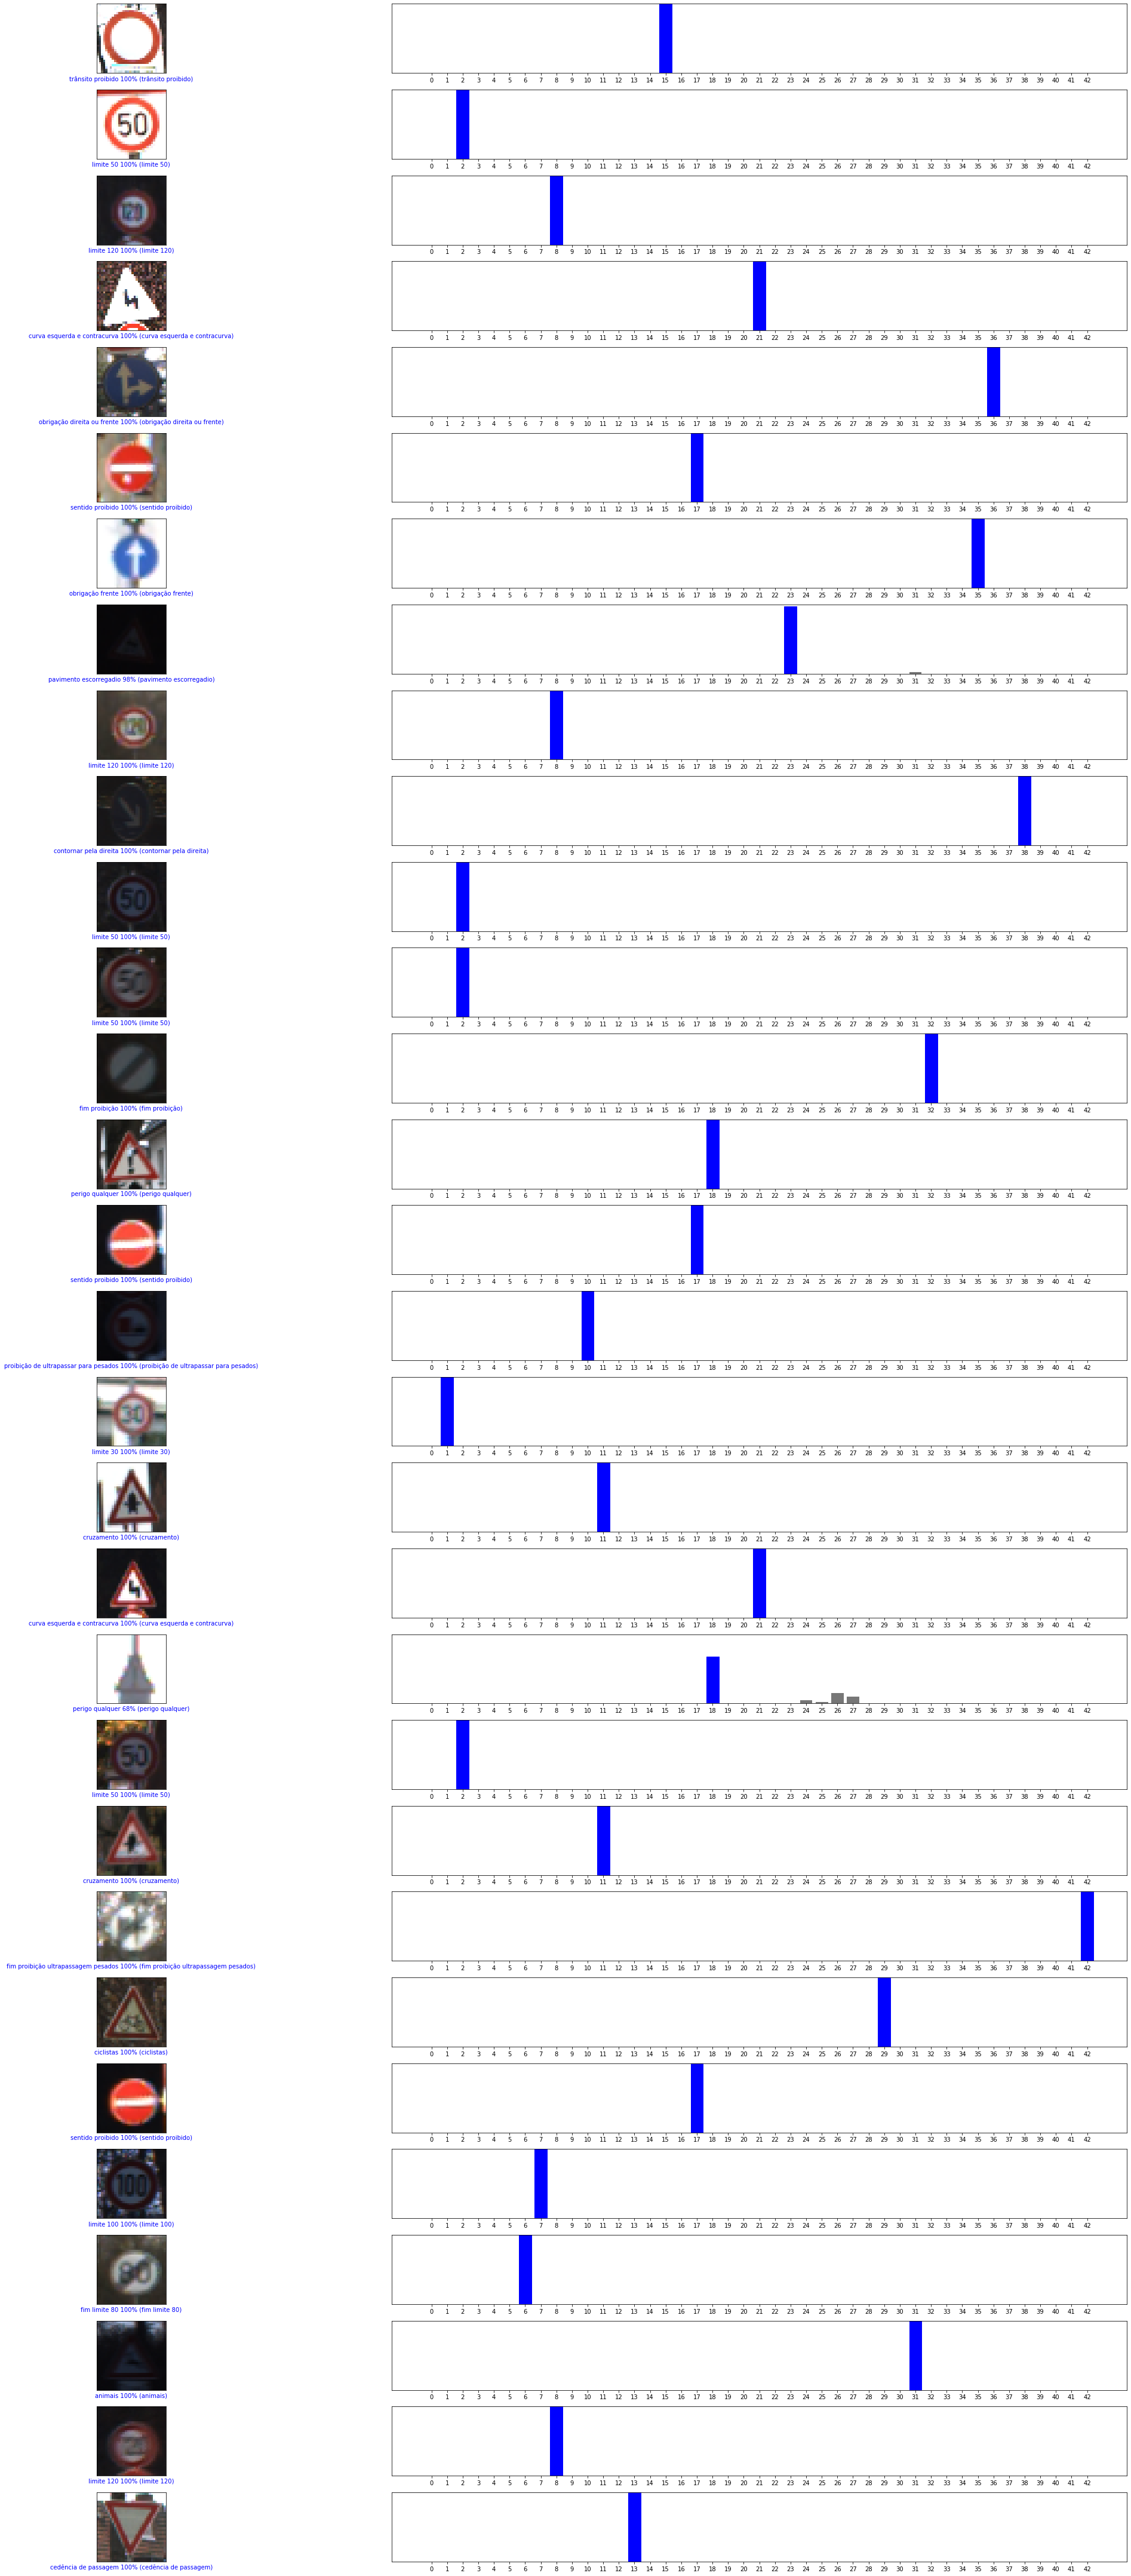

In [17]:

class_names = np.array(['limite 20','limite 30', 'limite 50', 'limmite 60', 'limite 70', 'limite 80', 'fim limite 80', 'limite 100', 'limite 120', 'proibição de ultrapassar', 'proibição de ultrapassar para pesados', 'cruzamento', 'via com prioridade', 'cedência de passagem', 'stop', 'trânsito proibido', 'trânsito proibido mercadorias', 'sentido proibido', 'perigo qualquer', 'curva esquerda', 'curva direita', 'curva esquerda e contracurva', 'lomba ou depressão', 'pavimento escorregadio', 'passagem estreita', 'trabalhos na via', 'sinalização luminosa', 'travessia de peões', 'crianças', 'ciclistas', 'neve', 'animais', 'fim proibição', 'obrigação direita', 'obrigação esquerda', 'obrigação frente', 'obrigação direita ou frente', 'obrigação frente ou esquerda', 'contornar pela direita', 'contornar pela esquerda', 'obrigação rotunda', 'fim proibição ultrapassagem', 'fim proibição ultrapassagem pesados'])

def plot_image(predictions_array, true_label, img):
  #predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
    
  plt.imshow(img, cmap=plt.cm.binary)
  
    
  predicted_label = np.argmax(predictions_array)
  true_label = np.argmax(true_label)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(predictions_array, true_label):
  #predictions_array, true_label = predictions_array, true_label[i]
  true_label = np.argmax(true_label)
  plt.grid(False)
  plt.xticks(range(43))
  plt.yticks([])
  thisplot = plt.bar(range(43), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 30
num_cols = 1
num_images = num_rows*num_cols
plt.figure(figsize=(8*2*2*num_cols, 2*num_rows))
j=0
for i in testset.take(1):
  a = model.predict(i)
  image,label = i
  for j in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*j+1)
    plot_image(a[j], label.numpy()[j], image.numpy()[j])
    plt.subplot(num_rows, 2*num_cols, 2*j+2)
    plot_value_array(a[j], label.numpy()[j])
  
plt.tight_layout()
plt.show()

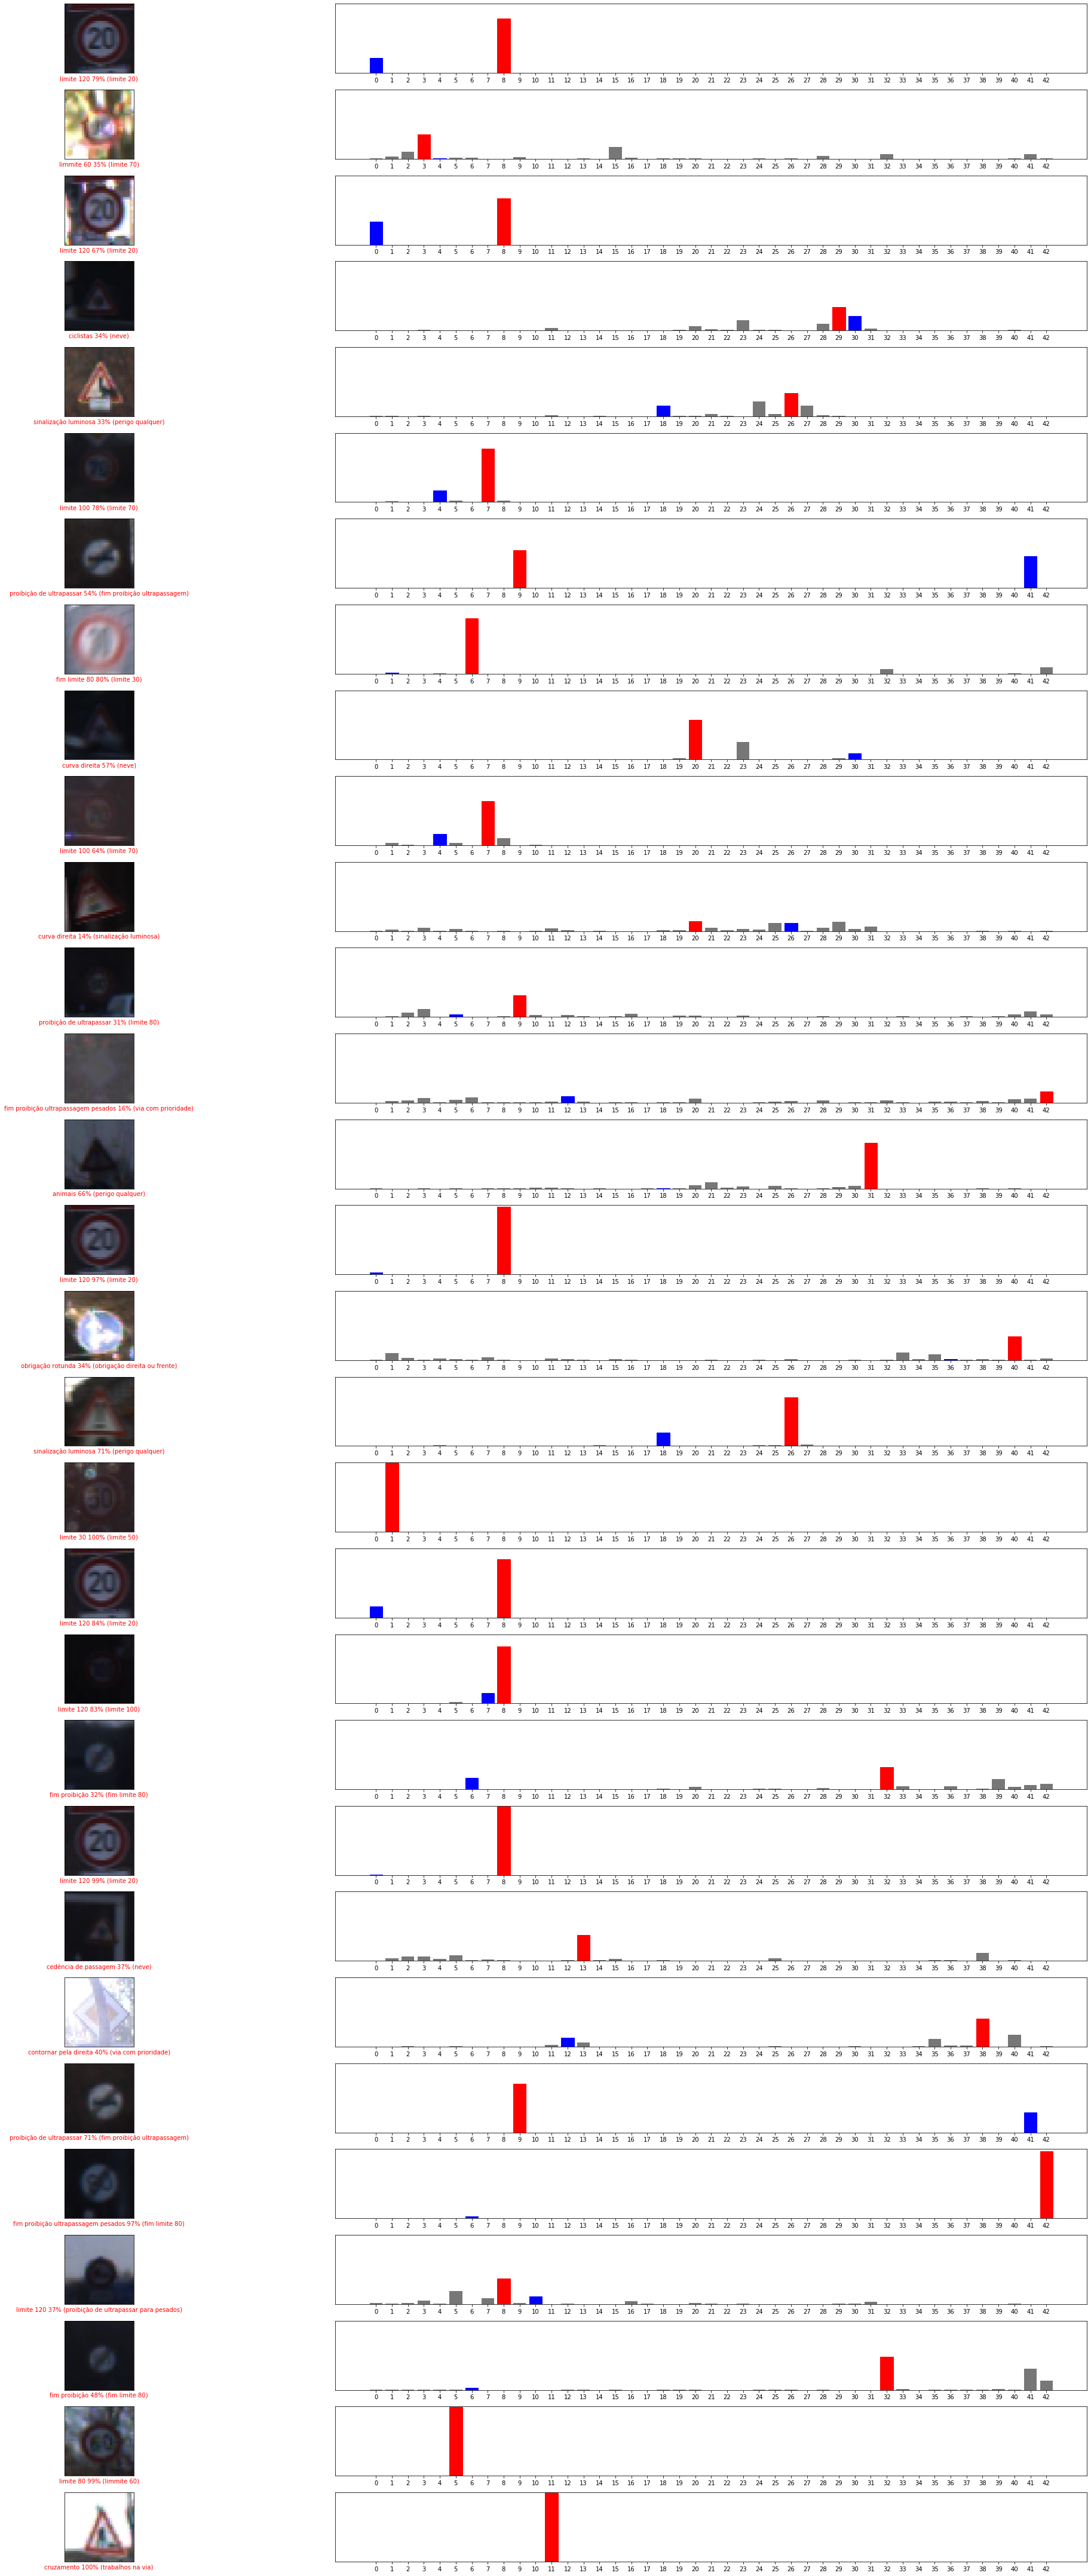

In [18]:

class_names = np.array(['limite 20','limite 30', 'limite 50', 'limmite 60', 'limite 70', 'limite 80', 'fim limite 80', 'limite 100', 'limite 120', 'proibição de ultrapassar', 'proibição de ultrapassar para pesados', 'cruzamento', 'via com prioridade', 'cedência de passagem', 'stop', 'trânsito proibido', 'trânsito proibido mercadorias', 'sentido proibido', 'perigo qualquer', 'curva esquerda', 'curva direita', 'curva esquerda e contracurva', 'lomba ou depressão', 'pavimento escorregadio', 'passagem estreita', 'trabalhos na via', 'sinalização luminosa', 'travessia de peões', 'crianças', 'ciclistas', 'neve', 'animais', 'fim proibição', 'obrigação direita', 'obrigação esquerda', 'obrigação frente', 'obrigação direita ou frente', 'obrigação frente ou esquerda', 'contornar pela direita', 'contornar pela esquerda', 'obrigação rotunda', 'fim proibição ultrapassagem', 'fim proibição ultrapassagem pesados'])

def plot_image(predictions_array, true_label, img):
  #predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
    
  plt.imshow(img, cmap=plt.cm.binary)
  
    
  predicted_label = np.argmax(predictions_array)
  true_label = np.argmax(true_label)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)


def plot_value_array(predictions_array, true_label):
  #predictions_array, true_label = predictions_array, true_label[i]
  true_label = np.argmax(true_label)
  plt.grid(False)
  plt.xticks(range(43))
  plt.yticks([])
  thisplot = plt.bar(range(43), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 30
num_cols = 1
num_images = num_rows*num_cols
plt.figure(figsize=(8*2*2*num_cols, 2*num_rows))
errados=0
for i in testset.take(-1):
  a = model.predict(i)
  image,label = i
  for j in range(BATCH_SIZE):
    if np.argmax(a[j]) != np.argmax(label.numpy()[j]):
      plt.subplot(num_rows, 2*num_cols, 2*errados+1)
      plot_image(a[j], label.numpy()[j], image.numpy()[j])
      plt.subplot(num_rows, 2*num_cols, 2*errados+2)
      plot_value_array(a[j], label.numpy()[j])
      errados = errados + 1
    if errados >= num_images:
        break
  if errados >= num_images:
    break
  
plt.tight_layout()
plt.show()